# Necessary Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
import itertools
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# Loading the Dataset

In [3]:
# Path to the training directory
TRAINING_DIR = '/kaggle/input/anime-faces/data'  # Adjusted path to include the 'data' subdirectory
SIZE = 64

In [4]:
# Setup the training configuration
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Setup the image generator
gen = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(SIZE, SIZE),
    batch_size=16,
    class_mode='input'
)

Found 21551 images belonging to 1 classes.


In [6]:
# Custom layers and functions
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Seed settings for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
codings_size = 25

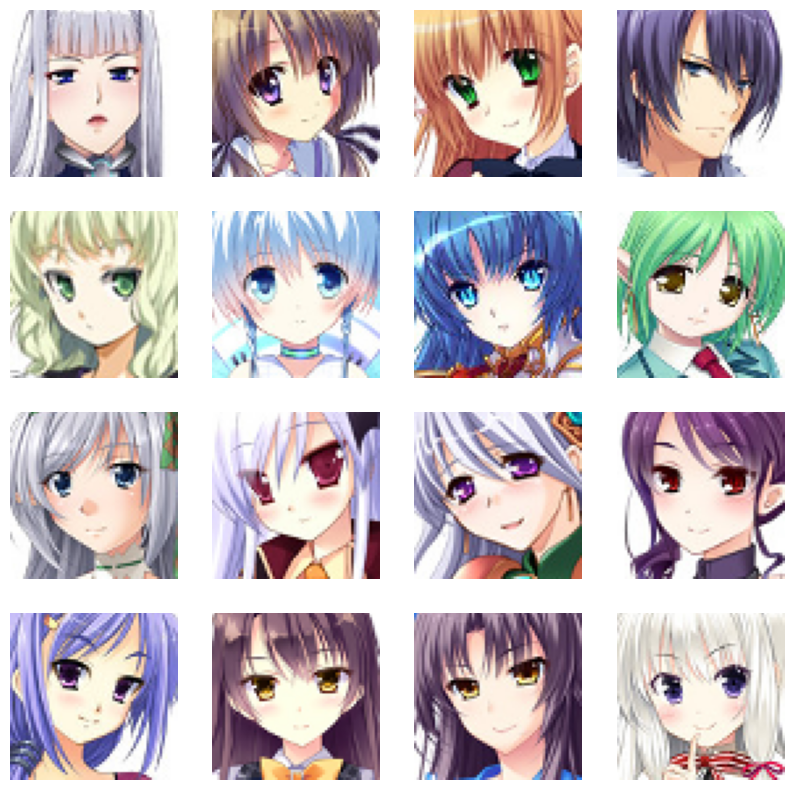

In [25]:
# Get a batch of images from the generator
sample_batch = next(gen)

# Extract images from the batch
sample_images = sample_batch[0]

# Plot the sample images"
plt.figure(figsize=(10, 10))
for i in range(16):  # Assuming batch size is 16
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.show()

# VAE-MODEL'S Architecture

## Encoder

In [8]:
# Building the encoder
inputs = keras.layers.Input(shape=[64, 64, 3])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(256, activation="selu")(z)
z = keras.layers.Dense(128, activation="selu")(z)
z = keras.layers.Dense(64, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)  # mean
codings_log_var = keras.layers.Dense(codings_size)(z)  # std deviation
codings = Sampling()([codings_mean, codings_log_var])  # codings
encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [9]:
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12288)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  3,145,984 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 25)        │      1,625 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25)        │      1,625 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 25)        │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,190,386 (12.17 MB)

 Trainable params: 3,190,386 (12.17 MB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [10]:
# Building the decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(64, activation="selu")(decoder_inputs)
x = keras.layers.Dense(128, activation="selu")(x)
x = keras.layers.Dense(256, activation="selu")(x)
x = keras.layers.Dense(512, activation="selu")(x)
x = keras.layers.Dense(1024, activation="selu")(x)
x = keras.layers.Dense(64 * 64 * 3, activation="sigmoid")(x)
outputs = keras.layers.Reshape([64, 64, 3])(x)
decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [11]:
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12288)          │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,295,104 (50.72 MB)

 Trainable params: 13,295,104 (50.72 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Combining into a VAE model
variational_ae = keras.models.Model(inputs=[inputs], outputs=decoder(encoder(inputs)[2]))
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])


In [13]:
# Training the model
history = variational_ae.fit(gen, epochs=40, shuffle=True)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   4/1347 ━━━━━━━━━━━━━━━━━━━━ 1:18 59ms/step - loss: 1.0753 - rounded_accuracy: 0.5032

I0000 00:00:1715440643.411827     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715440643.428156     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1074/1347 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 0.8478 - rounded_accuracy: 0.7053

W0000 00:00:1715440728.537918     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1347/1347 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 0.8037 - rounded_accuracy: 0.7139
Epoch 2/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5694 - rounded_accuracy: 0.7816
Epoch 3/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.5602 - rounded_accuracy: 0.7952
Epoch 4/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5548 - rounded_accuracy: 0.8028
Epoch 5/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5518 - rounded_accuracy: 0.8076
Epoch 6/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5491 - rounded_accuracy: 0.8111
Epoch 7/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5467 - rounded_accuracy: 0.8146
Epoch 8/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5456 - rounded_accuracy: 0.8163
Epoch 9/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5435 - rounded_accuracy: 0.8191
Epoch 10/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5426 - rounded_accuracy: 0.8199
Epoch 11/40
1347/1347 ━━━━━━━

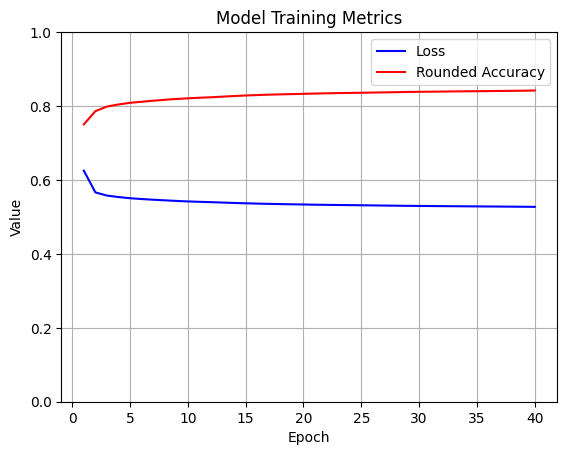

In [14]:
import matplotlib.pyplot as plt

# Extracting the loss and rounded accuracy values from the history
loss_values = history.history['loss']
rounded_accuracy_values = history.history['rounded_accuracy']

epochs = range(1, len(loss_values) + 1)

# Plotting the loss
plt.plot(epochs, loss_values, label='Loss', color='blue')
# Plotting the rounded accuracy
plt.plot(epochs, rounded_accuracy_values, label='Rounded Accuracy', color='red')

plt.title('Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1 for accuracy
plt.grid(True)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


W0000 00:00:1715441721.821879     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


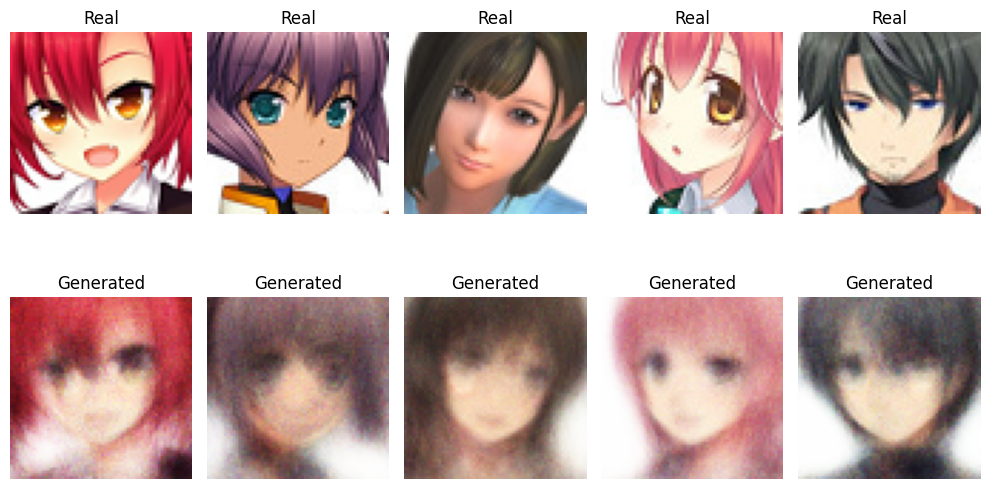

In [15]:
# Function to plot an image
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    images, _ = next(gen)
    reconstructions = model.predict(images[:n_images])
    
    plt.figure(figsize=(n_images * 2, 6))
    
    for img_index in range(n_images):
        # Plot real images
        plt.subplot(2, n_images, 1 + img_index)
        plot_image(images[img_index])
        plt.title("Real", fontsize=12)
        plt.axis("off")
        
        # Plot reconstructed images
        plt.subplot(2, n_images, 1 + n_images + img_index)
        plot_image(reconstructions[img_index])
        plt.title("Generated", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_reconstructions(variational_ae)

## Evaluation 

## FID-Score

In [16]:
# Function to calculate Frechet Inception Distance
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [17]:
# Function to preprocess images for InceptionV3
def preprocess_images(images, target_size):
    images = np.array([resize(image, (target_size, target_size), 0) for image in images])
    images = preprocess_input(images)
    return images

# Load InceptionV3 model
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
# Generate images
num_images = 100  # Number of images to generate for computing FID
real_images, _ = next(gen)
real_images = preprocess_images(real_images, 299)
generated_images = decoder.predict(np.random.normal(size=(num_images, codings_size)))
generated_images = preprocess_images(generated_images, 299)

# Calculate FID Score
fid_score = calculate_fid(inception, real_images, generated_images)
print(f"FID score: {fid_score}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
FID score:  2.269486225665967e+96


## Reconstruction Loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


W0000 00:00:1715441767.171938     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Reconstruction Loss: 0.5214895
Accuracy: 0.8370209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


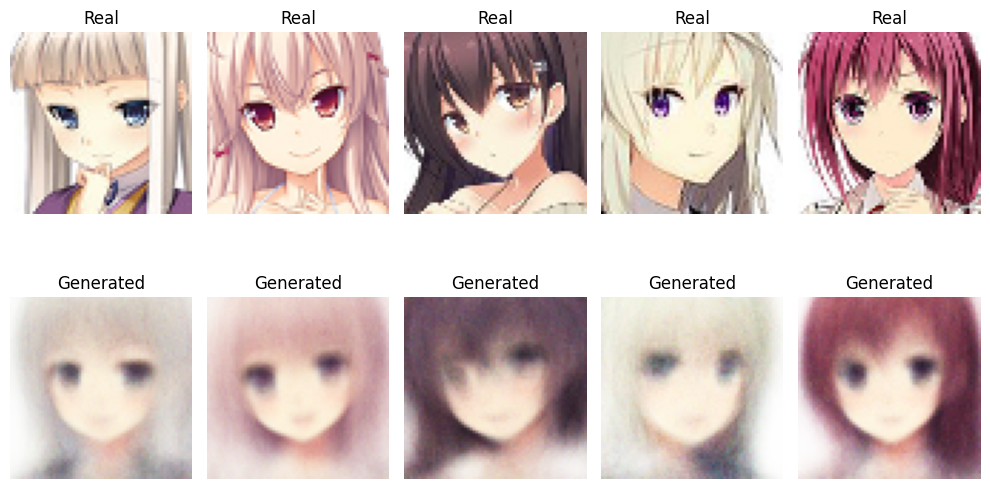

In [19]:
# Generate a batch of images
eval_images, _ = next(gen)

# Generate reconstructed images using the trained VAE model
reconstructions = variational_ae.predict(eval_images)

# Calculate reconstruction loss (e.g., binary cross-entropy)
reconstruction_loss = keras.metrics.binary_crossentropy(tf.convert_to_tensor(eval_images), tf.convert_to_tensor(reconstructions))

# Calculate overall accuracy
accuracy = rounded_accuracy(tf.convert_to_tensor(eval_images), tf.convert_to_tensor(reconstructions)).numpy().mean()

# Print reconstruction loss and accuracy
print("Reconstruction Loss:", reconstruction_loss.numpy().mean())
print("Accuracy:", accuracy)

# Visualize some example images and their reconstructions
show_reconstructions(variational_ae)


In [20]:
# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

## Inception Score

In [21]:
def calculate_inception_score(images, num_splits=10):
    # Preprocess the images for the InceptionV3 model
    processed_images = preprocess_input(images)
    
    # Generate predictions for each image
    preds = inception_model.predict(processed_images)
    
    # Split the predictions into num_splits groups
    scores = []
    for i in range(num_splits):
        split_preds = preds[i * (len(preds) // num_splits): (i + 1) * (len(preds) // num_splits)]
        # Calculate the softmax across classes for each prediction
        split_probs = np.exp(split_preds) / np.sum(np.exp(split_preds), axis=-1, keepdims=True)
        # Calculate the inception score for this split
        kl_divs = split_probs * (np.log(split_probs) - np.log(np.expand_dims(np.mean(split_probs, axis=0), axis=0)))
        kl_divs = np.mean(np.sum(kl_divs, axis=-1))
        scores.append(np.exp(kl_divs))
    
    # Return the mean and standard deviation of the inception scores
    return np.mean(scores), np.std(scores)

# Generate new samples from random points in the latent space
num_samples = 1000  # Number of samples to generate
latent_dim = codings_size  # Latent space dimension

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

# Decode the random latent vectors to generate images
generated_images = decoder.predict(random_latent_vectors)

# Rescale images to the required size for InceptionV3 (299x299)
generated_images_rescaled = np.array([resize(image, (299, 299, 3)) for image in generated_images])

# Calculate the Inception Score
is_mean, is_std = calculate_inception_score(generated_images_rescaled)
print("Inception Score (mean):", is_mean)
print("Inception Score (std):", is_std)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


W0000 00:00:1715441771.638303     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 400ms/step
Inception Score (mean): 1.0000246
Inception Score (std): 1.3871372e-06


# Hyper-Parameter Tuning

In [23]:
# Define the grid of hyper-parameters
hyper_params_grid = {
    'learning_rate': [0.001],
    'batch_size': [32,64],
    'epochs': [40]
}

best_accuracy = 0
best_hyper_params = {}

# Iterate through all combinations of hyper-parameters
for lr, batch_size, epochs in itertools.product(hyper_params_grid['learning_rate'], 
                                                 hyper_params_grid['batch_size'], 
                                                 hyper_params_grid['epochs']):
    print(f"Training with hyperparameters: Learning Rate={lr}, Batch Size={batch_size}, Epochs={epochs}")
    
    # Build and compile the model
    variational_ae = keras.models.Model(inputs=[inputs], outputs=decoder(encoder(inputs)[2]))
    variational_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=lr), metrics=[rounded_accuracy])
    
    # Train the model
    history = variational_ae.fit(gen, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)
    
    # Evaluate the model
    accuracy = history.history['rounded_accuracy'][-1]
    
    # Check if this set of hyper-parameters gives better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyper_params = {'learning_rate': lr, 'batch_size': batch_size, 'epochs': epochs}

Training with hyperparameters: Learning Rate=0.001, Batch Size=32, Epochs=40
Epoch 1/40
   6/1347 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.5271 - rounded_accuracy: 0.8362

W0000 00:00:1715442331.967904     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 133/1347 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - loss: 0.5249 - rounded_accuracy: 0.8434

W0000 00:00:1715442337.292740     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1347/1347 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 0.5264 - rounded_accuracy: 0.8429
Epoch 2/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.5264 - rounded_accuracy: 0.8428
Epoch 3/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5266 - rounded_accuracy: 0.8430
Epoch 4/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5259 - rounded_accuracy: 0.8438
Epoch 5/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.5261 - rounded_accuracy: 0.8438
Epoch 6/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5256 - rounded_accuracy: 0.8440
Epoch 7/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.5256 - rounded_accuracy: 0.8444
Epoch 8/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5252 - rounded_accuracy: 0.8445
Epoch 9/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.5252 - rounded_accuracy: 0.8448
Epoch 10/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5247 - rounded_accuracy: 0.8456
Epoch 11/40
1347/1347 ━━━━━━━━

W0000 00:00:1715443344.597795     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 886/1347 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.5191 - rounded_accuracy: 0.8530

W0000 00:00:1715443362.069020     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1347/1347 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.5193 - rounded_accuracy: 0.8528
Epoch 2/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5188 - rounded_accuracy: 0.8537
Epoch 3/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5194 - rounded_accuracy: 0.8534
Epoch 4/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5193 - rounded_accuracy: 0.8529
Epoch 5/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5187 - rounded_accuracy: 0.8537
Epoch 6/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.5188 - rounded_accuracy: 0.8535
Epoch 7/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5188 - rounded_accuracy: 0.8539
Epoch 8/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.5180 - rounded_accuracy: 0.8545
Epoch 9/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.5174 - rounded_accuracy: 0.8546
Epoch 10/40
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.5179 - rounded_accuracy: 0.8547
Epoch 11/40
1347/1347 ━━━━━━━━

In [24]:
# Print the best hyperparameters
print("Best hyperparameters:", best_hyper_params)

Best hyperparameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 40}
